# Model Evaluation Notebook
This notebook evaluates a trained model using SHAP and map which is connected to Streamlit.

In [1]:

# If you're missing any packages, uncomment the lines below and run.
# %pip install -q shap folium streamlit joblib scikit-learn
# If using conda/mamba, install via your preferred manager.

import os
import pandas as pd
import numpy as np
from pathlib import Path

# Core modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Optional libraries (graceful fallback if not present)
try:
    import shap
    SHAP_AVAILABLE = True
except Exception as e:
    SHAP_AVAILABLE = False
    print("⚠️ SHAP not available — install it to enable explainability (pip install shap).")

try:
    import folium
    FOLIUM_AVAILABLE = True
except Exception as e:
    FOLIUM_AVAILABLE = False
    print("⚠️ Folium not available — install it for heatmaps (pip install folium).")

DATA_PATH = Path('Dataset_Cities.csv')  # Uses your uploaded dataset
assert DATA_PATH.exists(), f"Dataset file not found at {DATA_PATH.resolve()}"


## 2) Load & Inspect Data

In [2]:

df = pd.read_csv(DATA_PATH)
print(f"Rows: {len(df):,}, Columns: {len(df.columns)}\n")
display(df.head(10))

print("\nColumn summary:\n")
display(pd.DataFrame({'dtype': df.dtypes.astype(str), 'nulls': df.isnull().sum()}))


Rows: 3,164, Columns: 11



,country,state,city,station,last_update,latitude,longitude,pollutant_id,pollutant_min,pollutant_max,pollutant_avg
0,India,Bihar,Aurangabad,"Gurdeo Nagar, Aurangabad - BSPCB",28-08-2025 19:00:00,24.757460,84.366208,PM10,25.0,166.0,73.0
1,India,Bihar,Begusarai,"Lohiyanagar, Begusarai - BSPCB",28-08-2025 19:00:00,25.427420,86.138861,NH3,3.0,4.0,4.0
2,India,Bihar,Bettiah,"Kamalnath Nagar, Bettiah - BSPCB",28-08-2025 19:00:00,26.803650,84.519540,PM10,5.0,59.0,32.0
3,India,Bihar,Bettiah,"Kamalnath Nagar, Bettiah - BSPCB",28-08-2025 19:00:00,26.803650,84.519540,NO2,5.0,12.0,8.0
4,India,Bihar,Bettiah,"Kamalnath Nagar, Bettiah - BSPCB",28-08-2025 19:00:00,26.803650,84.519540,CO,39.0,75.0,59.0
5,India,Bihar,Bettiah,"Kamalnath Nagar, Bettiah - BSPCB",28-08-2025 19:00:00,26.803650,84.519540,OZONE,23.0,25.0,24.0
6,India,Bihar,Bhagalpur,"DM Office_Kachari Chowk, Bhagalpur - BSPCB",28-08-2025 19:00:00,25.251013,86.989001,PM2.5,7.0,53.0,30.0
7,India,Bihar,Bhagalpur,"DM Office_Kachari Chowk, Bhagalpur - BSPCB",28-08-2025 19:00:00,25.251013,86.989001,NH3,2.0,4.0,3.0
8,India,Assam,Silchar,"Tarapur, Silchar - PCBA",28-08-2025 19:00:00,24.828270,92.795250,NH3,1.0,1.0,1.0
9,India,Assam,Sivasagar,"Girls College, Sivasagar - PCBA",28-08-2025 19:00:00,26.987634,94.636574,PM2.5,25.0,41.0,29.0



Column summary:



,dtype,nulls
country,object,0
state,object,0
city,object,0
station,object,0
last_update,object,0
latitude,float64,0
longitude,float64,0
pollutant_id,object,0
pollutant_min,float64,269
pollutant_max,float64,269


## 3) Data Cleaning & Feature Setup

In [3]:
# --- Configure your target & feature columns here ---
target_col = "pollutant_avg"
print(f"Using target: {target_col}")

# Drop rows where target is missing
df = df.dropna(subset=[target_col])

# Drop obvious label/location columns
drop_cols = ['country', 'state', 'city', 'station', 'last_update', 'latitude', 'longitude']

# Fill numeric NaNs with median
for c in ['pollutant_min', 'pollutant_max']:
    if df[c].isna().sum() > 0:
        df[c] = df[c].fillna(df[c].median())

# Separate features/target
X = df.drop(columns=[target_col])
y = df[target_col]

# Identify numeric and categorical features
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c]) and c not in drop_cols]
cat_cols = [c for c in X.columns if pd.api.types.is_string_dtype(X[c]) and c not in drop_cols]

print("Numeric features:", num_cols)
print("Categorical features:", cat_cols)

# Preprocess with OneHot for categoricals
preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# Build model pipeline
model = Pipeline(steps=[
    ('prep', preprocess),
    ('rf', RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

# Train/val split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"MAE: {mae:,.3f}")
print(f"R²:  {r2:,.3f}")

# Save model
joblib.dump({'model': model, 'features': X.columns.tolist(), 'target': target_col}, 'model.pkl')
print("Saved model → model.pkl")


Using target: pollutant_avg
Numeric features: ['pollutant_min', 'pollutant_max']
Categorical features: ['pollutant_id']
MAE: 3.779
R²:  0.926
Saved model → model.pkl


## 4) SHAP Explainability — Per-City

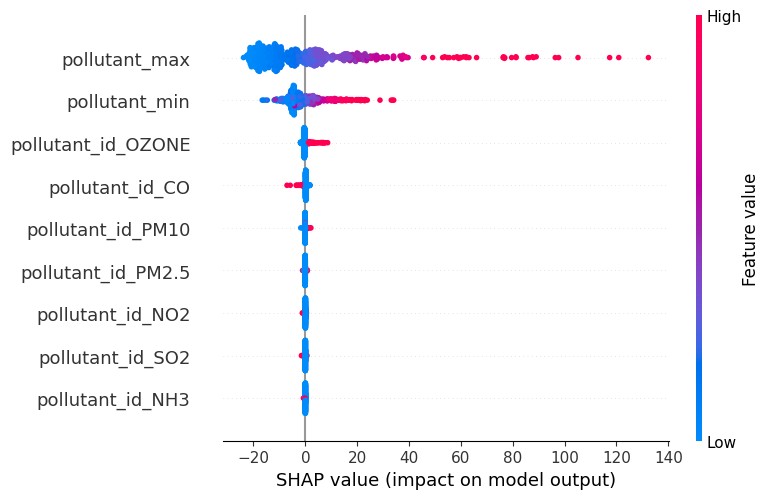

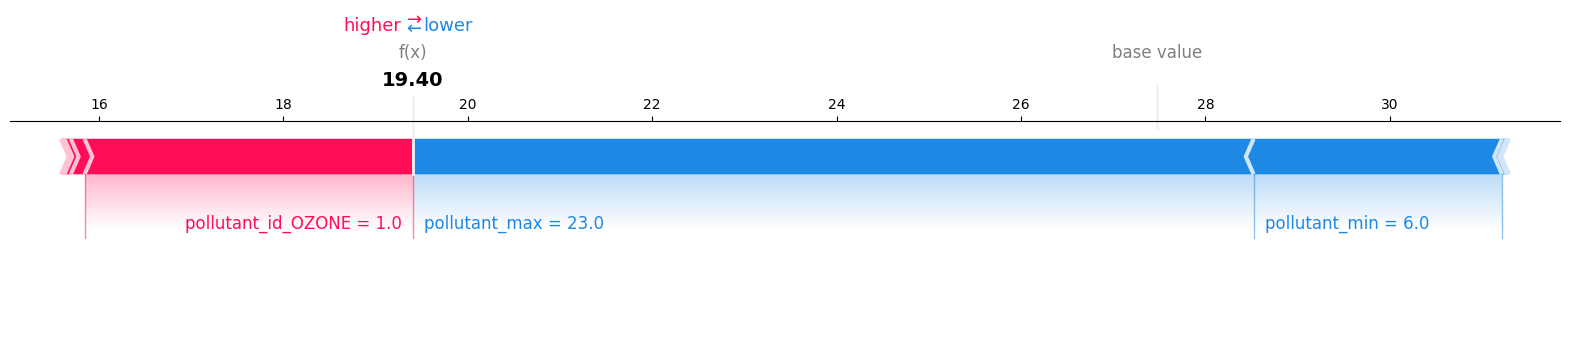

In [4]:

import matplotlib.pyplot as plt

if not SHAP_AVAILABLE:
    print("⚠️ SHAP not installed. Install with `pip install shap` and re-run this section.")
else:
    # We need to get a 2D numeric array post-preprocessing for SHAP
    # Use the pipeline to transform data
    X_test_transformed = model.named_steps['prep'].transform(X_test)
    # SHAP expects feature names; get them from preprocessor
    ohe = model.named_steps['prep'].named_transformers_['cat']
    num_feat_names = num_cols
    if len(cat_cols) > 0:
        cat_feat_names = ohe.get_feature_names_out(cat_cols).tolist()
    else:
        cat_feat_names = []
    feature_names = num_feat_names + cat_feat_names

    # TreeExplainer works for tree models; our final step is RandomForest
    try:
        explainer = shap.TreeExplainer(model.named_steps['rf'])
        shap_values = explainer.shap_values(X_test_transformed)
    except Exception as e:
        print("TreeExplainer failed, falling back to KernelExplainer (slower).", e)
        explainer = shap.KernelExplainer(model.predict, model.named_steps['prep'].transform(X_train[:200]))
        shap_values = explainer.shap_values(X_test[:50])  # sample for speed

    # Global importance
    plt.figure()
    shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.show()

    # Per-sample force plot — save one example (if supported by frontend)
    try:
        shap.initjs()
        i = 0
        sample_vals = shap_values[i] if isinstance(shap_values, np.ndarray) else shap_values[0][i]
        force = shap.force_plot(getattr(explainer, 'expected_value', 0), sample_vals, X_test_transformed[i], feature_names=feature_names, matplotlib=True, show=False)
        plt.show()
    except Exception as e:
        print("Force plot not available:", e)


## 5) Pollution Heatmap (Folium)

In [5]:
# --- Pollution Heatmap with Folium (forced import, no FOLIUM_AVAILABLE check) ---
import importlib

try:
    folium = importlib.import_module("folium")
except ImportError:
    raise ImportError("⚠️ Folium is not installed. Please run `pip install folium` in this environment.")

# Detect latitude/longitude columns (flexible)
lat_col = next((c for c in df.columns if c.lower() in ['latitude','lat']), None)
lon_col = next((c for c in df.columns if c.lower() in ['longitude','lon','lng','long']), None)

if lat_col is None or lon_col is None:
    raise ValueError("Latitude/Longitude columns not found. Please ensure your dataset has them.")

city_col = next((c for c in df.columns if c.lower() == 'city'), None)

# Map center
center_lat = float(df[lat_col].mean())
center_lon = float(df[lon_col].mean())

m = folium.Map(location=[center_lat, center_lon], zoom_start=5)

# Color scale based on quantiles of target
q = df[target_col].quantile([0.25, 0.5, 0.75]).values.tolist()
def color_for(v):
    if v <= q[0]: return 'green'
    if v <= q[1]: return 'orange'
    if v <= q[2]: return 'red'
    return 'darkred'

# Add circle markers
for _, row in df.iterrows():
    popup_txt = f"{target_col}: {row[target_col]:.2f}"
    if city_col:
        popup_txt = f"{row[city_col]} — " + popup_txt

    folium.CircleMarker(
        location=[row[lat_col], row[lon_col]],
        radius=7,
        popup=popup_txt,
        color=color_for(row[target_col]),
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# Save HTML map
m.save('pollution_heatmap.html')
print("✅ Saved interactive map → pollution_heatmap.html")


✅ Saved interactive map → pollution_heatmap.html
